In [1]:
from model_PyG import *
from utils import *

/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/ealva

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [3]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [4]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_weight))

### Setup

In [5]:
dataset = "vanessa_05" # "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		"Orange_1", "Orange_2",
		"Red_1", "Red_2",
		"Yellow_1", "Yellow_2",
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100
elif (dataset == "vanessa_05"):
	train_set = [
		"FrescoAmazonas_1", "FrescoAmazonas_2",
		"FrescoCusco_1", "FrescoCusco_2",
		"FrescoSanMartin_1", "FrescoSanMartin_2",
		"SecoAmazonas_1", "SecoAmazonas_2",
		"SecoCusco_1", "SecoCusco_2",
		"SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 150

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [6]:
transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

In [7]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		data = Data(x=x, edge_index=edge_index)
		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["vanessa_05", "mentos_05"]: # Change
	for i, ts in enumerate(train_set):
		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values, dtype=torch.long)
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float)

		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, intensity_mean, intensity_cv
		x = torch.tensor(df_nodes.iloc[:, 2:-1].values, dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)
		data = transform(data)
		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 559
Num. edges:	 211221
Num. features:	 3
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[  0,   0,   0,  ..., 556, 557, 558],
        [  1,   2,   3,  ..., 556, 557, 558]], device='cuda:0')
tensor([[1.6599e+02, 8.9000e-02, 6.3813e+00],
        [1.5801e+02, 9.0000e-02, 4.4425e+00],
        [1.7296e+02, 9.7000e-02, 6.6531e+00],
        ...,
        [1.3016e+02, 2.9926e+01, 7.7522e+00],
        [3.5234e+02, 2.9932e+01, 6.2737e+00],
        [2.5416e+02, 2.9944e+01, 6.9418e+00]], device='cuda:0')
tensor([-0.9526, -0.9993, -0.9598,  ...,  1.0000,  1.0000,  1.0000],
       device='cuda:0')
Validate:	 True
Num. nodes:	 559
Num. edges:	 212003
Num. features:	 3
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[  0,   0,   0,  ..., 556, 557, 558],
        [  1,   2,   3,  ..., 556, 557, 558]], device='cuda:0')
tensor([[1.6599e+02, 8.9000e-02, 6.4049e+00],
        

In [8]:
train_loader

{'FrescoAmazonas_1': Data(x=[559, 3], edge_index=[2, 211221], edge_weight=[211221]),
 'FrescoAmazonas_2': Data(x=[559, 3], edge_index=[2, 212003], edge_weight=[212003]),
 'FrescoCusco_1': Data(x=[559, 3], edge_index=[2, 207255], edge_weight=[207255]),
 'FrescoCusco_2': Data(x=[559, 3], edge_index=[2, 209835], edge_weight=[209835]),
 'FrescoSanMartin_1': Data(x=[559, 3], edge_index=[2, 210423], edge_weight=[210423]),
 'FrescoSanMartin_2': Data(x=[559, 3], edge_index=[2, 212347], edge_weight=[212347]),
 'SecoAmazonas_1': Data(x=[559, 3], edge_index=[2, 207225], edge_weight=[207225]),
 'SecoAmazonas_2': Data(x=[559, 3], edge_index=[2, 210145], edge_weight=[210145]),
 'SecoCusco_1': Data(x=[559, 3], edge_index=[2, 204647], edge_weight=[204647]),
 'SecoCusco_2': Data(x=[559, 3], edge_index=[2, 205343], edge_weight=[205343]),
 'SecoSanMartin_1': Data(x=[559, 3], edge_index=[2, 206353], edge_weight=[206353]),
 'SecoSanMartin_2': Data(x=[559, 3], edge_index=[2, 205465], edge_weight=[205465])}

### Train

In [9]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [10]:
train_set

['FrescoAmazonas_1',
 'FrescoAmazonas_2',
 'FrescoCusco_1',
 'FrescoCusco_2',
 'FrescoSanMartin_1',
 'FrescoSanMartin_2',
 'SecoAmazonas_1',
 'SecoAmazonas_2',
 'SecoCusco_1',
 'SecoCusco_2',
 'SecoSanMartin_1',
 'SecoSanMartin_2']

In [11]:
def fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]
			x = data.x
			edge_index = data.edge_index
			
			# Encoder
			z = model(x, edge_index)
			# z = F.normalize(z, dim=1)

			# Positive edges
			pos_edge_index = edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			z = model(data.x, data.edge_index).detach()
			dict_node_embeddings[ts] = z.cpu().numpy()

	torch.cuda.empty_cache()

	return dict_node_embeddings, list_loss

In [12]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

model = TGAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
vanessa_05 0.0001 150 3 128 12


Epoch: 150: 100%|██████████| 150/150 [04:31<00:00,  1.81s/it, Loss: 1.6520] 


### Get embeddings

In [13]:
dict_node_embeddings

{'FrescoAmazonas_1': array([[ 0.0812558 , -0.01844222,  0.12089707, ..., -0.09961017,
         -0.26539674, -0.13691737],
        [ 0.09730036, -0.10531639,  0.03418548, ..., -0.10979216,
         -0.15760407, -0.1445401 ],
        [ 0.08117079, -0.01359059,  0.12907535, ..., -0.09990538,
         -0.2812883 , -0.13732862],
        ...,
        [-0.39729077,  1.0677867 ,  0.69353116, ...,  0.19634916,
          0.74662024,  0.06290677],
        [-0.2960036 ,  0.7049301 ,  0.46742558, ...,  0.11785448,
          0.7865173 , -0.00266065],
        [-0.3411308 ,  0.8664747 ,  0.5682849 , ...,  0.15277106,
          0.7685911 ,  0.02646957]], dtype=float32),
 'FrescoAmazonas_2': array([[ 0.08105184, -0.01733871,  0.1220385 , ..., -0.09948289,
         -0.2667341 , -0.13681342],
        [ 0.0985778 , -0.11181998,  0.02803197, ..., -0.11063968,
         -0.15052533, -0.145191  ],
        [ 0.08168698, -0.01621002,  0.12661825, ..., -0.1002637 ,
         -0.27846533, -0.13759425],
        ...,

### Plot

In [14]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(6708, 128)


array([[ 0.0812558 , -0.01844222,  0.12089707, ..., -0.09961017,
        -0.26539674, -0.13691737],
       [ 0.09730036, -0.10531639,  0.03418548, ..., -0.10979216,
        -0.15760407, -0.1445401 ],
       [ 0.08117079, -0.01359059,  0.12907535, ..., -0.09990538,
        -0.2812883 , -0.13732862],
       ...,
       [-0.24696009,  0.5524759 ,  0.39458704, ...,  0.07882323,
         0.7315055 , -0.03556667],
       [-0.27411392,  0.6675263 ,  0.48758727, ...,  0.09817167,
         0.65676576, -0.02013696],
       [-0.2739897 ,  0.62766814,  0.41958848, ...,  0.10098577,
         0.7920448 , -0.01664368]], dtype=float32)

In [15]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
    labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

6708
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [16]:
list_loss

[13709.7958984375,
 5210.537109375,
 1977.68212890625,
 1829.12646484375,
 2490.35888671875,
 2722.691650390625,
 2542.357421875,
 2238.515625,
 1878.3001708984375,
 1414.7138671875,
 965.7457275390625,
 709.3717041015625,
 684.347900390625,
 763.0274658203125,
 796.2540283203125,
 740.7156982421875,
 639.6519775390625,
 539.0084838867188,
 451.08453369140625,
 376.7571716308594,
 324.7890625,
 300.53729248046875,
 291.18231201171875,
 277.0274353027344,
 252.04293823242188,
 224.0840301513672,
 199.08030700683594,
 175.14268493652344,
 150.95828247070312,
 130.8344268798828,
 118.48918151855469,
 110.8641357421875,
 102.38934326171875,
 92.34685516357422,
 84.1828384399414,
 79.25765991210938,
 74.79042053222656,
 67.53245544433594,
 57.27117919921875,
 46.748512268066406,
 39.516212463378906,
 37.17452621459961,
 37.611595153808594,
 36.68540954589844,
 32.6494026184082,
 27.94116973876953,
 25.425338745117188,
 24.546260833740234,
 22.87386131286621,
 19.909835815429688,
 17.1676959

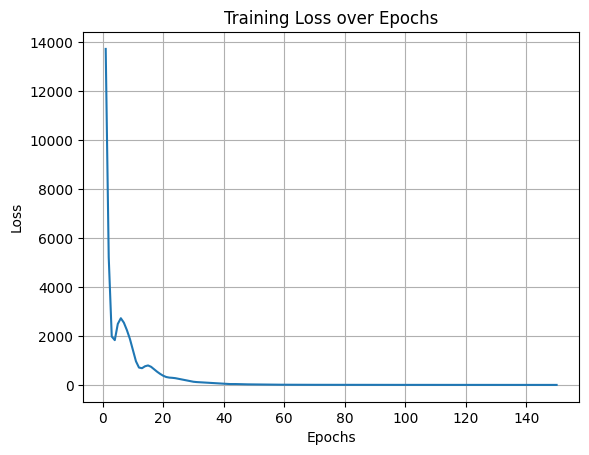

In [17]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

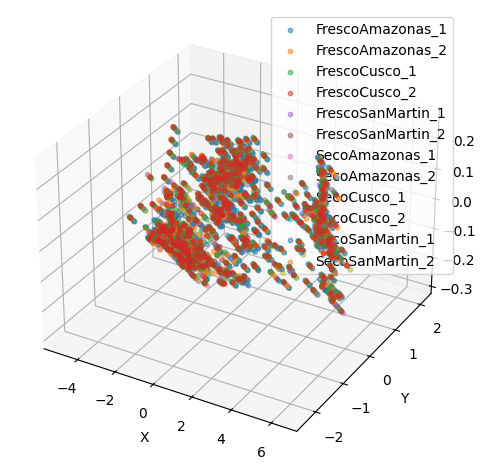

In [18]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

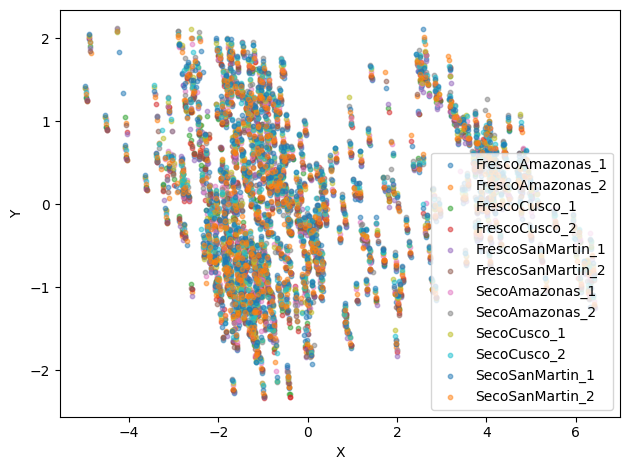

In [19]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()

### Similarity analysis (KNN)

In [20]:
train_set

['FrescoAmazonas_1',
 'FrescoAmazonas_2',
 'FrescoCusco_1',
 'FrescoCusco_2',
 'FrescoSanMartin_1',
 'FrescoSanMartin_2',
 'SecoAmazonas_1',
 'SecoAmazonas_2',
 'SecoCusco_1',
 'SecoCusco_2',
 'SecoSanMartin_1',
 'SecoSanMartin_2']

In [21]:
# Get node ids

dict_node_id = {}

if dataset in ["vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
    for ts in train_set:
        dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'FrescoAmazonas_1': array([  0,   1,   2,   4,   5,   7,   9,  12,  13,  14,  15,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  39,  40,  42,  43,  44,  45,  46,  47,
         49,  50,  51,  53,  55,  56,  57,  59,  61,  65,  66,  67,  68,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,  97,
         98,  99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 112, 113,
        115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 132, 133, 136, 137, 138, 139, 140, 142, 143, 146, 147,
        152, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169,
        171, 172, 174, 176, 177, 178, 179, 180, 182, 183, 185, 186, 188,
        189, 190, 191, 193, 195, 196, 198, 199, 200, 201, 202, 203, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217, 225, 226,
        228, 229, 230, 232, 235

In [22]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	
	df_node_alignment[ts] = dict_node_id[ts][indices]
df_node_alignment

,FrescoAmazonas_1,FrescoAmazonas_2,FrescoCusco_1,FrescoCusco_2,FrescoSanMartin_1,FrescoSanMartin_2,SecoAmazonas_1,SecoAmazonas_2,SecoCusco_1,SecoCusco_2,SecoSanMartin_1,SecoSanMartin_2
0,0,0,0,7,0,0,4,2,4,4,2,7
1,1,1,1,1,1,1,1,61,61,102,95,1
2,2,2,2,4,2,0,2,2,2,2,2,2
3,4,0,0,7,4,4,4,7,4,4,4,7
4,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
554,543,543,543,543,543,543,500,500,500,500,500,543
555,546,546,546,546,546,546,546,546,546,546,546,546
556,547,547,547,547,547,547,547,547,547,547,547,547
557,548,553,548,534,548,548,548,534,532,534,532,534


In [23]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

FrescoAmazonas_1 FrescoAmazonas_2


,FrescoAmazonas_1,FrescoAmazonas_2,FrescoCusco_1,FrescoCusco_2,FrescoSanMartin_1,FrescoSanMartin_2,SecoAmazonas_1,SecoAmazonas_2,SecoCusco_1,SecoCusco_2,SecoSanMartin_1,SecoSanMartin_2
0,0,0,0,7,0,0,4,2,4,4,2,7
1,1,1,1,1,1,1,1,61,61,102,95,1
2,2,2,2,4,2,0,2,2,2,2,2,2
4,5,5,5,5,5,5,5,5,5,5,5,5
6,9,9,8,8,9,7,3,3,3,3,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...
551,538,538,538,538,538,538,535,538,538,535,552,535
553,542,542,542,542,542,542,542,525,542,542,542,542
554,543,543,543,543,543,543,500,500,500,500,500,543
555,546,546,546,546,546,546,546,546,546,546,546,546


In [24]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
df_node_alignment_filter

,FrescoAmazonas_1,FrescoAmazonas_2,FrescoCusco_1,FrescoCusco_2,FrescoSanMartin_1,FrescoSanMartin_2,SecoAmazonas_1,SecoAmazonas_2,SecoCusco_1,SecoCusco_2,SecoSanMartin_1,SecoSanMartin_2
4,5,5,5,5,5,5,5,5,5,5,5,5
14,20,20,20,20,20,20,20,20,20,20,20,20
15,21,21,21,21,21,21,21,21,21,21,21,21
16,22,22,22,22,22,22,22,22,22,22,22,22
17,23,23,23,23,23,23,23,23,23,23,23,23
18,24,24,24,24,24,24,24,24,24,24,24,24
22,29,29,29,29,29,29,29,29,29,29,29,29
23,30,30,30,30,30,30,30,30,30,30,30,30
80,100,100,100,100,100,100,100,100,100,100,100,100
184,261,261,261,261,261,261,261,261,261,261,261,261


In [25]:
# Comparison (with test_pairs)

if dataset not in ["vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	test_pairs

	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	df_node_alignment[df_node_alignment["mask"] == True]

### Filter MS data

In [26]:
common_node_id = df_node_alignment_filter.iloc[:, 1].values
common_node_id

array([  5,  20,  21,  22,  23,  24,  29,  30, 100, 261, 264, 321, 343,
       351, 363, 366, 367, 377, 379, 382, 400, 403, 412, 431, 436, 442,
       444, 445, 446, 448, 450, 451, 452, 453, 464, 470, 522, 528, 537,
       539, 558, 150, 432, 433, 167, 244, 247, 251, 253, 262, 269, 283,
       291, 310, 424, 455, 456, 546, 547])

In [27]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/raw.csv".format(dataset), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,...,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_1.1,FrescoAmazonas_1.2,FrescoAmazonas_1.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
0,0.089,165.99460,NaN,1.213131e+06,1.177177e+06,1.566258e+05,1.731480e+06,1.699705e+06,6.280596e+06,1.696391e+06,...,3.338787e+05,1.133971e+06,1.808500e+05,3.342117e+05,4.322203e+06,1.821127e+06,1.770069e+06,1.743055e+06,1.463076e+06,6.428159e+06
1,0.090,158.01272,"[Similar to: 1-benzylhexahydropyrimidine-2,4,6...",1.431372e+04,2.609972e+04,5.571270e+03,4.865791e+04,3.923473e+04,8.001311e+03,3.985529e+04,...,4.652185e+03,3.434351e+04,2.178133e+04,3.596103e+03,5.631005e+04,4.148497e+04,9.098716e+03,2.515887e+04,5.974290e+04,5.789815e+03
2,0.097,172.95681,NaN,3.406202e+06,8.569343e+06,2.299997e+06,1.344103e+07,1.831757e+06,1.657309e+06,1.042663e+07,...,2.008602e+06,6.643525e+06,6.447431e+06,2.520397e+06,1.275967e+07,1.578762e+06,4.518729e+06,9.966807e+06,4.552709e+05,1.402781e+07
3,0.191,167.01326,NaN,5.020429e+07,4.827342e+07,1.113485e+06,6.889062e+07,6.861163e+07,2.800838e+07,6.561428e+07,...,2.189862e+06,4.159900e+07,4.101282e+07,1.728290e+06,7.507800e+07,7.443810e+07,3.294308e+07,6.365119e+07,6.403714e+07,2.607451e+07
4,0.196,165.98329,NaN,2.429038e+06,2.564504e+06,1.071655e+06,1.040565e+07,5.333877e+05,1.667311e+06,2.812425e+06,...,1.433978e+06,9.607175e+05,5.082268e+06,2.935405e+06,4.686568e+06,3.386707e+06,7.763971e+05,1.503685e+06,7.711962e+06,2.505585e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,29.965,341.26686,Docosahexaenoic acid,8.376403e+06,8.179919e+06,1.137834e+07,1.124024e+07,1.109478e+07,1.698218e+07,7.006518e+06,...,9.237098e+06,7.589148e+06,6.798410e+06,8.014118e+06,1.125906e+07,7.940634e+06,2.003224e+06,7.171052e+06,8.523936e+06,1.454813e+07
555,29.966,178.15937,N-Propylamphetamine,3.290299e+07,3.307227e+07,6.826276e+07,4.771023e+07,4.564733e+07,7.901293e+07,4.210922e+07,...,5.918501e+07,2.785011e+07,2.457465e+07,1.308641e+07,4.774097e+07,6.472719e+07,1.092961e+08,3.954838e+07,3.810093e+07,8.150158e+07
556,29.969,707.49253,NaN,1.537170e+07,1.921792e+07,4.989073e+06,2.964074e+07,2.545159e+07,5.389525e+06,2.626919e+07,...,2.580318e+06,1.344052e+07,1.132973e+07,1.192044e+06,3.228213e+07,2.365662e+07,3.800210e+06,2.567993e+07,6.028380e+06,1.913270e+06
557,29.969,165.11386,2-piperazinopyrimidine,2.308164e+06,2.275392e+06,6.454852e+06,1.710127e+06,3.178837e+06,8.738433e+06,1.248976e+06,...,5.209212e+06,1.847576e+06,1.788281e+06,1.986319e+06,3.774866e+06,3.512772e+06,1.176852e+07,2.692574e+06,2.835947e+06,7.170966e+06


In [28]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
5,0.201,144.98254,NaN
20,1.939,430.91457,NaN
21,1.939,498.90208,"[Similar to: 2-(4-chlorophenyl)-2-oxoethyl 2,6..."
22,1.939,566.88963,NaN
23,1.939,634.87705,NaN
24,1.939,702.86447,NaN
29,1.944,668.87054,NaN
30,1.949,446.88860,NaN
100,2.352,264.95513,NaN
261,9.912,680.24361,NaN


In [29]:
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
5,0.201,144.98254,NaN
20,1.939,430.91457,NaN
21,1.939,498.90208,"[Similar to: 2-(4-chlorophenyl)-2-oxoethyl 2,6..."
22,1.939,566.88963,NaN
23,1.939,634.87705,NaN
24,1.939,702.86447,NaN
29,1.944,668.87054,NaN
30,1.949,446.88860,NaN
100,2.352,264.95513,NaN
261,9.912,680.24361,NaN
